<a href="https://colab.research.google.com/github/danielyangdev/CAIS-F23-Curriculum/blob/main/%5BL4%5D_Intro_to_Natural_Language_Processing_Fine_Tuning_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Advantages of Finetuning**

Feel free to skip this explanation, but it's here if you need a refresher, or if you are new to the concept of transfer learning!

In this notebook, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need?

1. **Quicker Development**

    * First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!).

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.



Since we'll be training a large neural network it's best to take advantage of Collab's GPU, otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Install `transformers`.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Loading CoLA Dataset**

We'll use [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. It was first published in May of 2018, and is one of the tests included in the "GLUE Benchmark" on which models like BERT are competing.


### **Download & Extract**

We'll use the `wget` package to download the dataset to the Colab instance's file system.

In [ ]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wget
import os

print('Downloading dataset...')
# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Unzip the dataset to the file system. You can browse the file system of the Colab instance in the sidebar on the left.

In [ ]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

## **Parse**

We can see from the file names that both `tokenized` and `raw` versions of the data are available.

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
2448,l-93,1,NaN,There appeared a ship on the horizon.
8295,ad03,1,NaN,Did you drink the poison?
1290,r-67,1,NaN,Aunt Hattie wants you to be nice and kiss your...
7941,ad03,1,NaN,There was a dragon in the cave.
1316,r-67,0,*,Sally's sick and what did you bring me?
2609,l-93,0,*,Lora buttered unsalted butter on the toast.
8109,ad03,1,NaN,"Raffi slept well, and Gillian will too"
5376,b_73,1,NaN,He gave me more of his marbles than I wanted.
5394,b_73,0,*,She speaks enough clearly to be understood.
1754,r-67,0,??,The more contented the nurses began to believe...


The two properties we actually care about are the the `sentence` and its `label`, which is referred to as the "acceptibility judgment" (0=unacceptable, 1=acceptable).

Here are five sentences which are labeled as not grammatically acceptible. Note how much more difficult this task is than something like sentiment analysis!

In [ ]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
2801,Paula hit the sticks.,0
413,John to call would be unlikely.,0
6772,Because Dr Jones ate too much rich food didn't...,0
1141,He figured out it.,0
1635,Bill left when I believe the claim that the bo...,0




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

## **Tokenization & Input Formatting**

In this section, we'll transform our dataset into the format that BERT can be trained on.

### **BERT Tokenizer**

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #TODO----------

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately.

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

### **Required Formatting**

The above code left out a few required formatting steps that we'll look at here.

We are required to:
1. Add **special tokens** to the start and end of each sentence.
2. **Pad & truncate** all sentences to a single constant length.
3. Explicitly **differentiate real tokens from padding tokens** with the "attention mask".

**Special Tokens**

**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token.

**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

**Sentence Length and Attention Mask**

The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="https://drive.google.com/uc?export=view&id=1cb5xeqLu_5vPOgs3eRnail2Y00Fl2pCo" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.


### **Tokenize Dataset**

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us. Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = ['[CLS]'] + tokenizer.tokenize(sent) + ['[SEP]'] #TODO-----------

    # Update the maximum sentence length.
    max_len = len(input_ids) if len(input_ids) > max_len else max_len #TODO----------

print('Max sentence length: ', max_len)

Max sentence length:  47


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but we'll using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [ ]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        #TODO----------,                      # Sentence to encode.
                        add_special_tokens = #TODO----------, # Add '[CLS]' and '[SEP]'
                        max_length = #TODO----------,           # Pad & truncate all sentences.
                        pad_to_max_length = #TODO----------,
                        return_attention_mask = #TODO----------,   # Construct attn. masks.
                        return_tensors = #TODO----------,     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## **Training & Validation Split**


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = #TODO----------

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order (RandomSampler)
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially (SequentialSampler)
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

##**Train Our Classification Model**

Now that our input data is properly formatted, it's time to fine tune the BERT model.

### **Bert For Sequence Classification**



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top; ensure the model does NOT outputs attentions and hidden_states
model = BertForSequenceClassification.from_pretrained(#TODO----------)

# Tell pytorch to run this model on the GPU.
model.cuda()

### **Optimizer & Learning Rate Scheduler**

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

In [ ]:
# Define the optimizer
optimizer = #TODO----------

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
epochs = #TODO----------

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = #TODO----------

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### **Training Loop**

Helper function to compute accuracy.

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready to kick off the training!

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = #TODO----------
        b_input_mask = #TODO----------
        b_labels = #TODO----------

        # 0 the gradients
        model.zero_grad()

        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=#TODO----------,
                       labels=#TODO----------,
                       return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(#TODO----------)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:16.
  Batch    80  of    241.    Elapsed: 0:00:29.
  Batch   120  of    241.    Elapsed: 0:00:43.
  Batch   160  of    241.    Elapsed: 0:00:56.
  Batch   200  of    241.    Elapsed: 0:01:10.
  Batch   240  of    241.    Elapsed: 0:01:23.

  Average training loss: 0.50
  Training epcoh took: 0:01:23

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.45
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:40.
  Batch   160  of    241.    Elapsed: 0:00:53.
  Batch   200  of    241.    Elapsed: 0:01:07.
  Batch   240  of    241.    Elapsed: 0:01:20.

  Average training loss: 0.32
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.46
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
 

Let's view the summary of the training process.

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.50,0.45,0.80,0:01:23,0:00:03
2,0.32,0.46,0.83,0:01:20,0:00:03
3,0.20,0.51,0.83,0:01:20,0:00:03
4,0.15,0.57,0.84,0:01:21,0:00:03


How is your model doing?

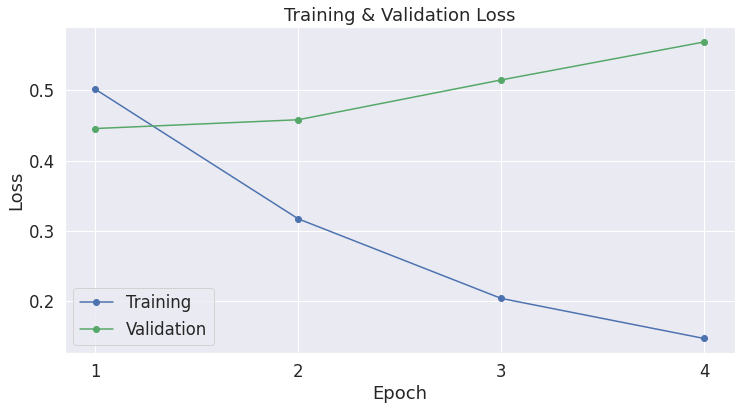

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## **Performance On Test Set**

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.


We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



### **Evaluate on Test Set**



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


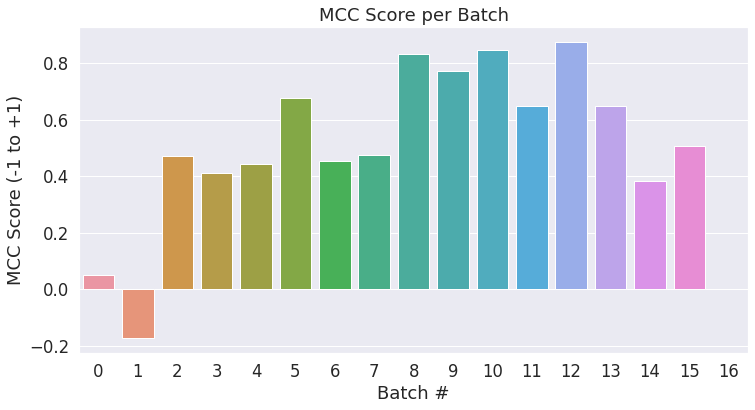

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.545


Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score.

> *Note: To maximize the score, we should remove the "validation set" (which we used to help determine how many epochs to train for) and train on the entire training set.*

The library documents the expected accuracy for this benchmark [here](https://huggingface.co/transformers/examples.html#glue) as `49.23`.

You can also look at the official leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy).

Note that (due to the small dataset size?) the accuracy can vary significantly between runs.


##*Fin!*